In [1]:
import cv2
import numpy as np
import os
import joblib as jb

# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

# Importing Silhouette Score implementation from scikit-learn
from sklearn.metrics import silhouette_score

# Importing feature extraction tools
from skimage.feature import greycomatrix, greycoprops
import mahotas as mt # Mahotas library for GLCM calculation
from skimage import feature # feature.local_binary_pattern for LBP calculation

# Importing visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Importing projection tools
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Importing pre-processing tool
from sklearn.preprocessing import StandardScaler

# Importing classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Importing model selection tools
from sklearn.model_selection import StratifiedKFold, cross_val_score

In this notebook we'll use images obtained from the combination of the data augmentation and object highlighting procedures.

In [2]:
train_path = './waste_images/train_segmented_balanced'  
training_names = os.listdir(train_path)

image_paths = [] # Get path to all images and save them in a list
image_classes = [] # Corresponding labels in image_paths
class_id = 0

# To make it easy to list all file names in a directory let us define a function
def imglist(path):    
    return [os.path.join(path, f) for f in os.listdir(path)]

# Fill the placeholder empty lists with image path, classes, and add class ID number
for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [3]:
image_paths[:10]

['./waste_images/train_segmented_balanced\\Aluminium\\Aluminium18_segmented.JPG',
 './waste_images/train_segmented_balanced\\Aluminium\\Aluminium1_segmented.JPG',
 './waste_images/train_segmented_balanced\\Aluminium\\Aluminium21_segmented.JPG',
 './waste_images/train_segmented_balanced\\Aluminium\\Aluminium26_segmented.JPG',
 './waste_images/train_segmented_balanced\\Aluminium\\Aluminium30_segmented.JPG',
 './waste_images/train_segmented_balanced\\Aluminium\\Aluminium31_segmented.JPG',
 './waste_images/train_segmented_balanced\\Aluminium\\Aluminium32_segmented.JPG',
 './waste_images/train_segmented_balanced\\Aluminium\\Aluminium37_segmented.JPG',
 './waste_images/train_segmented_balanced\\Aluminium\\Aluminium3_segmented.JPG',
 './waste_images/train_segmented_balanced\\Aluminium\\Aluminium40_segmented.JPG']

In [4]:
# Total number of images in the training set
len(image_paths)

499

In [5]:
# Classes
np.unique(image_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [6]:
# Examples of images

In [7]:
np.random.seed(2150)
idx_sample = np.random.choice(len(image_paths), size = 9, replace = False)
idx_sample = idx_sample.astype('int')
len(idx_sample)

9

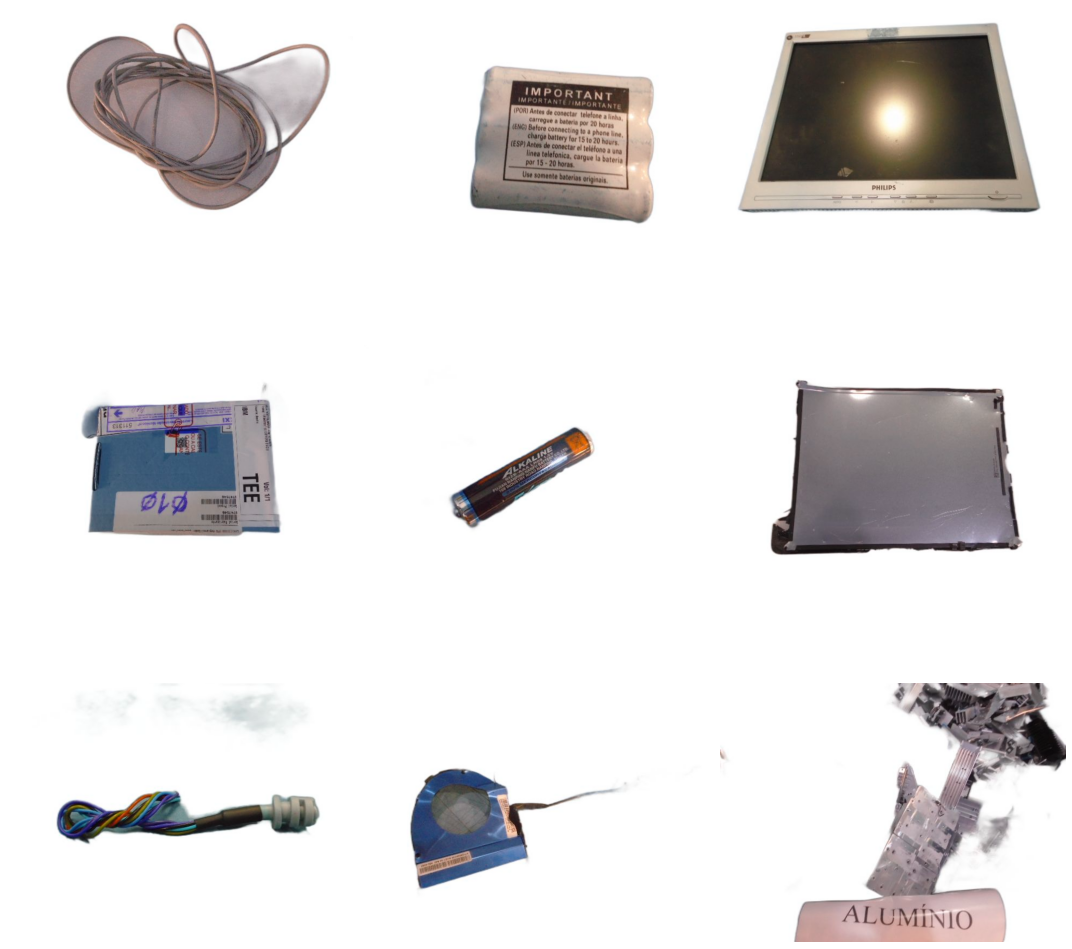

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))
img = cv2.imread(image_paths[idx_sample[0]]); axs[0, 0].imshow(img); axs[0,0].axis('off')
img = cv2.imread(image_paths[idx_sample[1]]); axs[0, 1].imshow(img); axs[0,1].axis('off')
img = cv2.imread(image_paths[idx_sample[2]]); axs[0, 2].imshow(img); axs[0,2].axis('off')
img = cv2.imread(image_paths[idx_sample[3]]); axs[1, 0].imshow(img); axs[1,0].axis('off')
img = cv2.imread(image_paths[idx_sample[4]]); axs[1, 1].imshow(img); axs[1,1].axis('off')
img = cv2.imread(image_paths[idx_sample[5]]); axs[1, 2].imshow(img); axs[1,2].axis('off')
img = cv2.imread(image_paths[idx_sample[6]]); axs[2, 0].imshow(img); axs[2,0].axis('off')
img = cv2.imread(image_paths[idx_sample[7]]); axs[2, 1].imshow(img); axs[2,1].axis('off')
img = cv2.imread(image_paths[idx_sample[8]]); axs[2, 2].imshow(img); axs[2,2].axis('off')
plt.tight_layout()
plt.show()

# BRISK - Feature Point Detector

Binary Robust Invariant Scalable Keypoints (BRISK) is a feature point detection and description algorithm with scale and rotation invariance. It constructs the feature descriptor of the local image through the gray scale relationship of random point pairs in the neighborhood of the local image, and obtains the binary feature descriptor. 

More detailed information at:

S. Leutenegger, M. Chli and R. Y. Siegwart, "BRISK: Binary Robust invariant scalable keypoints," 2011 _International Conference on Computer Vision_, 2011, pp. 2548-2555, doi: 10.1109/ICCV.2011.6126542.

In [18]:
# Create feature extraction and keypoint detector objects
# SIFT is not available anymore in openCV    

# Create list where all the descriptors will be stored
des_list = []

# BRISK is a good replacement to SIFT.
brisk = cv2.BRISK_create(30)

for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = brisk.detectAndCompute(im, None)
    des_list.append((image_path, des))

In [19]:
# Initialize vector to stack
descriptors = des_list[0][1]
descriptors

array([[254, 255, 255, ..., 205, 153,  59],
       [248, 255, 255, ..., 137, 153,  19],
       [160,  59, 223, ...,   8, 153, 186],
       ...,
       [ 75, 255, 175, ..., 207, 151, 191],
       [255, 255, 255, ...,  73,   0, 128],
       [ 75, 230,  60, ...,   0,  83,  98]], dtype=uint8)

In [20]:
# Stack all the descriptors vertically into a numpy array
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))

In [21]:
print(descriptors.shape)
descriptors

(364329, 64)


array([[254, 255, 255, ..., 205, 153,  59],
       [248, 255, 255, ..., 137, 153,  19],
       [160,  59, 223, ...,   8, 153, 186],
       ...,
       [254, 221, 255, ...,   8,  17,   0],
       [252, 255, 255, ..., 255, 189,  27],
       [240, 255, 239, ..., 207, 159,  63]], dtype=uint8)

In [22]:
# kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float)

## Clustering

In order to analyze the best possible number of clusters, we'll take a sample of the descriptors dataset and run the clustering algorithm with different values of __k__ and then use _Silhoutte Score_ to decide the best option.

In [23]:
np.random.seed(1658)

In [24]:
sample_idx = np.random.choice(descriptors_float.shape[0], size = int(descriptors_float.shape[0]*0.1), replace = False)
descriptors_sample = descriptors_float[sample_idx]
print(descriptors_sample.shape)

(36432, 64)


In [25]:
# Recommendation is to explore between 25 and 1,000 clusters
n_clusters = np.arange(25, 1000, 50)
scores=[]
dict_nclusters_scores = {}

for k in n_clusters:
    voc_sample, _ = kmeans(descriptors_sample, k, 1) 
    clusters, _ = vq(descriptors_sample, voc_sample)
    score = silhouette_score(descriptors_sample, clusters)
    scores.append(score)
    dict_nclusters_scores[k] = score

In [26]:
dict_nclusters_scores

{25: 0.0266621404410638,
 75: 0.02105147920412786,
 125: 0.019242412343635763,
 175: 0.018451092146966514,
 225: 0.017861962737426258,
 275: 0.01799427051461827,
 325: 0.018301285422733807,
 375: 0.018202129072999677,
 425: 0.017827045159729455,
 475: 0.01798615697869812,
 525: 0.01823923647433734,
 575: 0.017821798806420788,
 625: 0.01858851536440142,
 675: 0.018446931913642016,
 725: 0.01887807777399401,
 775: 0.018540149931353268,
 825: 0.019285621314524732,
 875: 0.018921283127342717,
 925: 0.018915570658141506,
 975: 0.018514628001757055}

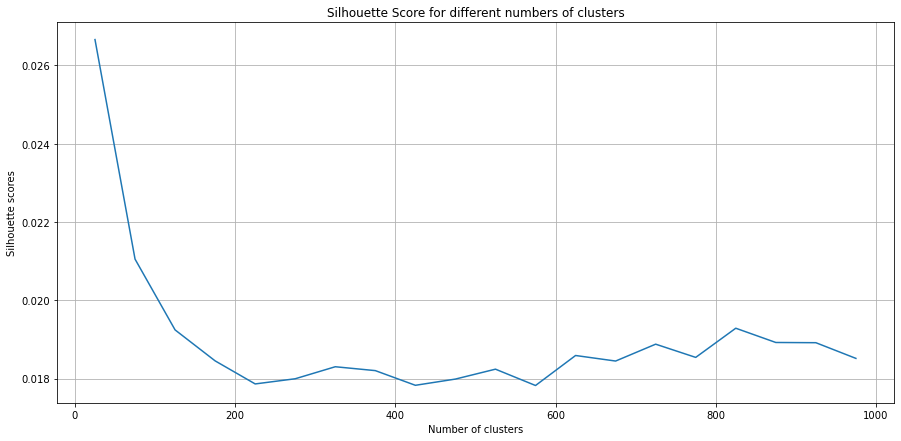

In [27]:
fig=plt.figure(figsize=(15,7))
plt.title("Silhouette Score for different numbers of clusters")
plt.plot(n_clusters, scores)
plt.ylabel("Silhouette scores")
plt.xlabel("Number of clusters")
plt.grid()

The silhouette scores suggests that the clusters obtained do not provide good segmentation for the data. Either way, as we can see in the chart above, k=25 clusters has the best result among the ones tested. So let's carry on with the analysis using k=25 and clusterize the whole dataset.

In [28]:
# Apply kmeans for the whole dataset of descriptors with k = 25
k = 25
voc, variance = kmeans(descriptors_float, k, 1)

In [29]:
print(voc.shape)
voc

(25, 64)


array([[190.45572644, 100.96573092,  78.43556816, ..., 150.36075855,
        110.92989398, 100.39323578],
       [103.64661565,  68.39692709, 133.36471496, ...,  90.07504301,
        102.63997153, 110.40280002],
       [152.56107522, 192.46417168, 196.93420955, ..., 170.76297616,
        165.76787703, 116.50219054],
       ...,
       [168.96602381, 134.48005291, 186.07456659, ..., 109.88289355,
         97.14154425, 116.69017615],
       [191.64974237, 230.95262033, 231.51859997, ..., 165.02475807,
        138.37526706, 130.17688827],
       [ 89.3776115 , 144.17602608, 146.31308342, ...,  58.36368351,
         89.48696103, 106.45666025]])

In [30]:
variance

618.9170013298556

In [31]:
clusters, _ = vq(descriptors_float, voc)
print(clusters.shape)

(364329,)


## Extracted Features Visualization

In [32]:
descriptors_cluster = np.hstack((descriptors_float,clusters.reshape(-1, 1)))
print(descriptors_cluster.shape)

(364329, 65)


### Principal Component Analysis __(PCA)__

In [33]:
def plot_pca(dataset):
    pca = PCA()
    pca_data = pca.fit_transform(dataset[:, :-1])
    array = pca.explained_variance_ratio_
    array = [round(elem, 4) for elem in array]
    array_acum = [0]*len(array)
    for i in range(len(array)):
        if i == 0:
            array_acum[i] = array[i]
        else:
            array_acum[i] = array_acum[i-1] + array[i]
    print('3 principal components explained variance: {}'.format(array[:3]))

    pca_data = np.hstack((pca_data, dataset[:, -1].reshape(-1, 1).astype('int')))

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs[0].plot(array_acum)
    axs[0].set_title('PCA cumulative explained variance by component')
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=pca_data[:, -1], palette='turbo', legend=False, ax=axs[1])
    axs[1].set_title('Two principal components point cloud hued by cluster')
    plt.axis('off')
    plt.show()

3 principal components explained variance: [0.0929, 0.0789, 0.0653]


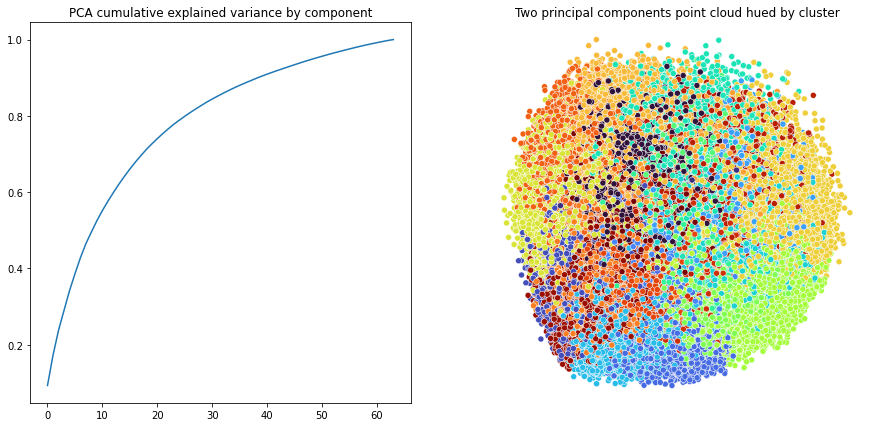

In [25]:
plot_pca(descriptors_cluster)

The first chart shows the cumulative explained variance obtained from PCA applied to the descriptors dataset. The second chart shows the point clould hued by the clusters previously obtained, also from the descriptors dataset. This visual representation doesn't aid on extracting any insights from the descriptors. This is likely due to the facts that the first two components from PCA explain together only 17.2% of the data variance and the low silhoutte score obtained for the clusters.

### t-Distributed Stochastic Neighbor Embedding __(t-SNE)__

t-distributed Stochastic Neighbor Embedding (t-SNE) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two-dimensional map.

In [34]:
sample_tsne = np.random.choice(descriptors_cluster.shape[0], size = int(descriptors_cluster.shape[0]*0.01), replace = False)
descriptors_cluster_sample = descriptors_cluster[sample_tsne]

In [35]:
def plot_tsne(dataset):
    tsne_data = TSNE(n_components=2, perplexity=30).fit_transform(dataset[:, :-1])
    tsne_data = np.hstack((tsne_data, dataset[:, -1].reshape(-1, 1)))
    fig = plt.subplots(figsize=(7, 7))
    sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=tsne_data[:, -1].astype('int'), palette='turbo', legend=False)
    plt.title('t-SNE 2 components visualization of descriptors obtained')
    plt.axis('off')
    plt.show()

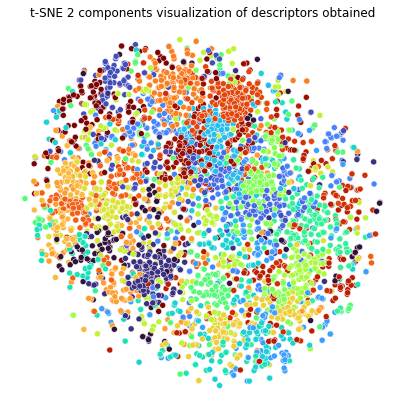

In [36]:
plot_tsne(descriptors_cluster_sample)

In the chart above we see the point cloud of the 2D projection produced by t-SNE procedure. Each color represent a cluster obtained from descriptors provided by the BRISK method.

## Training

In [29]:
# Calculate the histogram of features and represent them as vector
# vq assigns codes from a code book to observations

im_features = np.zeros((len(image_paths), k), "float32")

for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1

In [30]:
print(im_features.shape)
im_features

(499, 25)


array([[32., 13., 39., ..., 12., 56., 58.],
       [ 2.,  3.,  9., ...,  0.,  2.,  2.],
       [ 1.,  0.,  6., ...,  0.,  8.,  1.],
       ...,
       [40.,  1., 28., ..., 14., 28., 36.],
       [32.,  1., 24., ..., 12., 24., 32.],
       [15.,  1., 11., ...,  6., 23., 17.]], dtype=float32)

In [31]:
# Scaling the features
# Standardize features by removing the mean and scaling to unit variance
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [32]:
# Classifiers
classifiers = []
classifiers.append(('Logistic Regression', LogisticRegression(random_state=0, multi_class='multinomial', penalty='l2', solver='lbfgs')))
classifiers.append(('Multi-Layer Perceptron', MLPClassifier(random_state=0, activation='logistic', solver='lbfgs', warm_start=True)))
classifiers.append(('Support Vector Machine', SVC(random_state=0, kernel='rbf', C=1.0, gamma=10)))
classifiers.append(('Decision Tree', DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=20, min_samples_split=15, max_features='auto', min_impurity_decrease=1e-4)))
classifiers.append(('Random Forest', RandomForestClassifier(random_state=0, criterion='entropy', min_samples_split=30, max_depth=50, n_estimators=50)))
classifiers.append(('XGBoost', XGBClassifier(random_state=0, eval_metric='auc')))

In [33]:
def classifiers_func(im_features, image_classes):
    results = []
    models = []
    for model, clf in classifiers:
        cv = StratifiedKFold(n_splits=5)
        score = cross_val_score(clf, im_features, np.array(image_classes), cv=cv, scoring='accuracy', n_jobs=-1)
        results.append(score)
        models.append(model)
        msg = "%s: %f (%f)" % (model, score.mean(), score.std())
        print(msg)
    return results, models

In [34]:
results_brisk, models_brisk = classifiers_func(im_features, image_classes)

Logistic Regression: 0.242566 (0.042193)
Multi-Layer Perceptron: 0.222465 (0.044992)
Support Vector Machine: 0.120222 (0.016606)
Decision Tree: 0.168343 (0.020441)
Random Forest: 0.294566 (0.059409)
XGBoost: 0.242505 (0.031386)


Random Forest got the highest accuracy in the cross validation training. So we'll fit this model in the entire train dataset of features.

In [35]:
# Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train Random Forest
clf = RandomForestClassifier(random_state=0, criterion='entropy', min_samples_split=30, max_depth=50, n_estimators=50)
clf.fit(im_features, np.array(image_classes))

RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_split=30,
                       n_estimators=50, random_state=0)

In [36]:
# Save the model parameters
# Joblib dumps Python object into one file
jb.dump((clf, training_names, stdSlr, k, voc), "bovw_segmented_balanced_brisk_rf.pkl", compress=3)

['bovw_segmented_balanced_brisk_rf.pkl']

# GLCM Haralick Features

We'll use haralick feature extraction implemented in the Mahotas package.
Haralick texture features are calculated from a Gray Level Co-occurrence Matrix, (GLCM), a matrix that counts the co-occurrence of neighboring gray levels in the image. Mahota's implementations contemplates the first 13 features from Haralick's original work. They are: (1) Angular Second Moment, (2) Contrast, (3) Correlation, (4) Variance, (5) Inverse Difference Moment, (6) Sum Average, (7) Sum Variance, (8) Sum (9) Entropy, (10) Difference Variance, (11) Difference Entropy and (12 and 13) Information Measures of Correlation.

In [37]:
# Create List where all the descriptors will be stored
des_list = []

In [38]:
def extract_glcm_features(image):
    # Calculate haralick texture features for 4 types of adjacency
    textures = mt.features.texture.haralick(image)
    return textures

In [39]:
for image_path in image_paths:
    im = cv2.imread(image_path)
    gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale
    des = extract_glcm_features(gray_img)
    des_list.append((image_path, des))

In [40]:
len(des_list)

499

In [41]:
des_list[0][1].shape

(4, 13)

In [42]:
descriptors = des_list[0][1]
descriptors

array([[ 2.63089912e-01,  5.60060576e+01,  9.93208420e-01,
         4.12319822e+03,  6.85702471e-01,  3.95983007e+02,
         1.64367868e+04,  4.81738953e+00,  6.45570460e+00,
         1.50172148e-03,  2.46878843e+00, -5.01483077e-01,
         9.93333426e-01],
       [ 2.60037202e-01,  9.95492304e+01,  9.87933447e-01,
         4.12500708e+03,  6.32024159e-01,  3.95744976e+02,
         1.64004791e+04,  4.83687382e+00,  6.76884832e+00,
         1.29748812e-03,  2.87977358e+00, -4.31345674e-01,
         9.87840197e-01],
       [ 2.63897707e-01,  4.82329201e+01,  9.94151676e-01,
         4.12365309e+03,  6.88430083e-01,  3.95923499e+02,
         1.64463794e+04,  4.81524145e+00,  6.39991398e+00,
         1.50364212e-03,  2.40679210e+00, -5.15037139e-01,
         9.94081144e-01],
       [ 2.60053661e-01,  9.68795580e+01,  9.88257043e-01,
         4.12500708e+03,  6.32792924e-01,  3.95744976e+02,
         1.64031488e+04,  4.83683448e+00,  6.76116158e+00,
         1.29930253e-03,  2.87066190e

In [43]:
# Stack all the descriptors vertically in a numpy array
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))

In [44]:
descriptors.shape

(1996, 13)

In [45]:
# kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float)

## Clustering

In order to analyze the best possible number of clusters, we'll take a sample of the descriptors dataset and run the clustering algorithm with different values of __k__ and then use _Silhoutte Score_ to decide the best option.

In [46]:
# Recommendation is to explore between 25 and 1,000 clusters
n_clusters = np.arange(25, 1000, 50)
scores=[]
dict_nclusters_scores = {}

for k in n_clusters:
    voc_sample, _ = kmeans(descriptors_float, k, 1) 
    clusters, _ = vq(descriptors_float, voc_sample)
    score = silhouette_score(descriptors_float, clusters)
    scores.append(score)
    dict_nclusters_scores[k] = score

In [47]:
dict_nclusters_scores

{25: 0.5410947410902316,
 75: 0.5247836136959882,
 125: 0.5046770126032201,
 175: 0.49051466393111254,
 225: 0.4824150514364973,
 275: 0.5137599628885061,
 325: 0.49271088177569144,
 375: 0.49588793759205557,
 425: 0.5068766329964438,
 475: 0.501770731599889,
 525: 0.4787937682487312,
 575: 0.4883087369381077,
 625: 0.4972120262341908,
 675: 0.4915872134922348,
 725: 0.4695191047781718,
 775: 0.47518724602648926,
 825: 0.4685368663663215,
 875: 0.43920194253100464,
 925: 0.450694442928589,
 975: 0.4409636567077086}

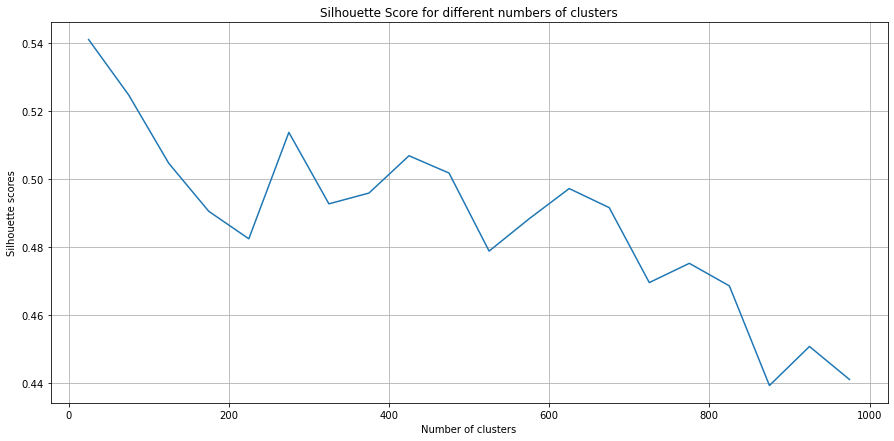

In [48]:
fig=plt.figure(figsize=(15,7))
plt.title("Silhouette Score for different numbers of clusters")
plt.plot(n_clusters, scores)
plt.ylabel("Silhouette scores")
plt.xlabel("Number of clusters")
plt.grid()

The silhouette scores of the clusters obtained from the GLCM descriptors show better segmentation than the ones from BRISK (the closer to 1 the better). k = 25 is also the best choice for this feature extraction method. Let's see if the visualizations provide better results.

In [49]:
# Apply kmeans for the whole dataset of descriptors with k = 25
k = 25
voc, variance = kmeans(descriptors_float, k, 1)

In [50]:
print(voc.shape)

(25, 13)


In [51]:
variance

376.43665443112343

In [52]:
clusters, _ = vq(descriptors_float, voc)
print(clusters.shape)

(1996,)


## Extracted Features Visualization

In [53]:
descriptors_cluster = np.hstack((descriptors_float,clusters.reshape(-1, 1)))
print(descriptors_cluster.shape)

(1996, 14)


### Principal Component Analysis __(PCA)__ 

In [54]:
def plot_pca(dataset):
    pca = PCA()
    pca_data = pca.fit_transform(dataset[:, :-1])
    array = pca.explained_variance_ratio_
    array = [round(elem, 4) for elem in array]
    array_acum = [0]*len(array)
    for i in range(len(array)):
        if i == 0:
            array_acum[i] = array[i]
        else:
            array_acum[i] = array_acum[i-1] + array[i]
    print('3 principal components explained variance: {}'.format(array[:3]))

    pca_data = np.hstack((pca_data, dataset[:, -1].reshape(-1, 1).astype('int')))

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs[0].plot(array_acum)
    axs[0].set_title('PCA cumulative explained variance by component')
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=pca_data[:, -1], palette='turbo', legend=False, ax=axs[1])
    axs[1].set_title('Two principal components point cloud hued by cluster')
    plt.axis('off')
    plt.show()

3 principal components explained variance: [0.9999, 0.0001, 0.0]


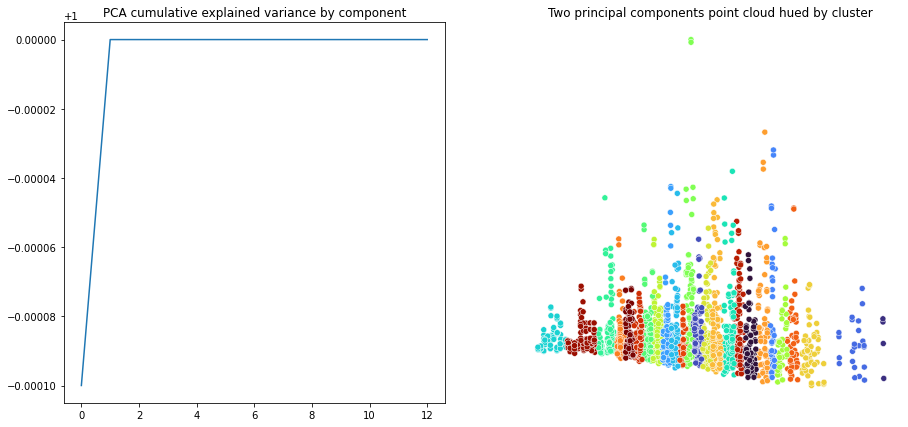

In [55]:
plot_pca(descriptors_cluster)

For GLCM, we can observe that nearly 100% of the variance is explained by the first component. This, alongside clusters that can better segment the data, produces good separation of the descriptors clusters, as seen in the 2D point cloud on the left-hand side chart.

### t-Distributed Stochastic Neighbor Embedding __(t-SNE)__

In [56]:
def plot_tsne(dataset):
    tsne_data = TSNE(n_components=2, perplexity=30).fit_transform(dataset[:, :-1])
    tsne_data = np.hstack((tsne_data, dataset[:, -1].reshape(-1, 1)))
    fig = plt.subplots(figsize=(7, 7))
    sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=tsne_data[:, -1].astype('int'), palette='turbo', legend=False)
    plt.title('t-SNE 2 components visualization of descriptors obtained')
    plt.axis('off')
    plt.show()

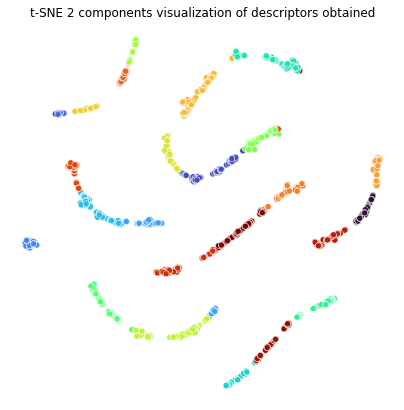

In [57]:
plot_tsne(descriptors_cluster)

The GLCM method produced less descriptors to the segmented pictures, that's why we see relatively few points in the chart above. The curious shape also reveals fairly well segmented clusters.

## Training

In [23]:
# Calculate the histogram of features and represent them as vector
# vq assigns codes from a code book to observations
im_features = np.zeros((len(image_paths), k), "float32")

for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1

In [24]:
im_features.shape

(499, 25)

In [25]:
# Scaling the features
# Standardize features by removing the mean and scaling to unit variance
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [26]:
# Classifiers
classifiers = []
classifiers.append(('Logistic Regression', LogisticRegression(random_state=0, multi_class='multinomial', penalty='l2', solver='lbfgs')))
classifiers.append(('Multi-Layer Perceptron', MLPClassifier(random_state=0, activation='logistic', solver='lbfgs', warm_start=True)))
classifiers.append(('Support Vector Machine', SVC(random_state=0, kernel='rbf', C=1.0, gamma=10)))
classifiers.append(('Decision Tree', DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=20, min_samples_split=15, max_features='auto', min_impurity_decrease=1e-4)))
classifiers.append(('Random Forest', RandomForestClassifier(random_state=0, criterion='entropy', min_samples_split=30, max_depth=50, n_estimators=50)))
classifiers.append(('XGBoost', XGBClassifier(random_state=0, eval_metric='auc')))

In [27]:
def classifiers_func(im_features, image_classes):
    results = []
    models = []
    for model, clf in classifiers:
        cv = StratifiedKFold(n_splits=5)
        score = cross_val_score(clf, im_features, np.array(image_classes), cv=cv, scoring='accuracy', n_jobs=-1)
        results.append(score)
        models.append(model)
        msg = "%s: %f (%f)" % (model, score.mean(), score.std())
        print(msg)
    return results, models

In [28]:
results_glcm, models_glcm = classifiers_func(im_features, image_classes)

Logistic Regression: 0.106242 (0.015199)
Multi-Layer Perceptron: 0.108222 (0.019419)
Support Vector Machine: 0.122283 (0.027322)
Decision Tree: 0.114263 (0.027435)
Random Forest: 0.124364 (0.037753)
XGBoost: 0.116263 (0.018752)


Random Forest got the best accuracy in the cross validation training. So we'll fit this model in the entire train dataset of features.

In [32]:
# Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train Random Forest
clf = RandomForestClassifier(random_state=0, criterion='entropy', min_samples_split=30, max_depth=50, n_estimators=50)
clf.fit(im_features, np.array(image_classes))

RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_split=30,
                       n_estimators=50, random_state=0)

In [33]:
# Save the Random Forest model
# Joblib dumps Python object into one file
jb.dump((clf, training_names, stdSlr, k, voc), "bovw_segmented_balanced_glcm_rf.pkl", compress=3) 

['bovw_segmented_balanced_glcm_rf.pkl']

# LBP - Local Binary Patterns

We'll use the scikit-image package implemenation of LBP.

In [58]:
# Create list where all the descriptors will be stored
des_list = []

In [59]:
def extract_lbp_features(img, radius=1, sampling_pixels=8):
    
    # LBP operates in single channel images so if RGB images are provided
    # we have to convert it to grayscale
    if (len(img.shape) > 2):
        img = img.astype(float)
        # RGB to grayscale convertion using Luminance
        img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

    # converting to uint8 type for 256 graylevels
    img = img.astype(np.uint8)
    
    # normalize values can also help improving description
    i_min = np.min(img)
    i_max = np.max(img)
    if (i_max - i_min != 0):
        img = (img - i_min)/(i_max-i_min)
    
    # compute LBP
    lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")
    
    '''
    # LBP returns a matrix with the codes, so we compute the histogram
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

    # normalization
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    # return the histogram of Local Binary Patterns
    return hist
    '''
    
    return lbp

In [60]:
for image_path in image_paths:
    im = cv2.imread(image_path)
    #gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale
    des = extract_lbp_features(im)
    des_list.append((image_path, des))

In [61]:
len(des_list)

499

In [62]:
des_list[0][1].shape

(480, 640)

In [63]:
descriptors = des_list[0][1]
descriptors

array([[3., 5., 5., ..., 5., 5., 3.],
       [5., 8., 8., ..., 8., 8., 5.],
       [5., 8., 8., ..., 8., 8., 5.],
       ...,
       [5., 8., 8., ..., 8., 8., 5.],
       [5., 8., 8., ..., 8., 8., 5.],
       [3., 5., 5., ..., 5., 5., 3.]])

In [64]:
removal_list = []

for image_path, descriptor in des_list[1:]:
    if (descriptor.shape[1] != (640)):
        #print(image_path, descriptor.shape)
        removal_list.append(image_path)

In [65]:
len(removal_list)

22

In [66]:
# Stack all the descriptors vertically in a numpy array
for image_path, descriptor in des_list[1:]:
    if image_path not in removal_list:
        #print(image_path)
        descriptors = np.vstack((descriptors, descriptor))

In [67]:
descriptors.shape

(228960, 640)

In [71]:
# kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float)

## Clustering

In order to analyze the best possible number of clusters, we'll take a sample of the descriptors dataset and run the clustering algorithm with different values of __k__ and then use _Silhoutte Score_ to decide the best option.

In [72]:
np.random.seed(1658)

In [73]:
sample_idx = np.random.choice(descriptors_float.shape[0], size = int(descriptors_float.shape[0]*0.1), replace = False)
descriptors_sample = descriptors_float[sample_idx]
print(descriptors_sample.shape)

(22896, 640)


In [74]:
# Recommendation is to explore between 25 and 1,000 clusters
n_clusters = np.arange(25, 1000, 50)
scores=[]
dict_nclusters_scores = {}

for k in n_clusters:
    voc_sample, _ = kmeans(descriptors_sample, k, 1) 
    clusters, _ = vq(descriptors_sample, voc_sample)
    score = silhouette_score(descriptors_sample, clusters)
    scores.append(score)
    dict_nclusters_scores[k] = score

In [75]:
dict_nclusters_scores

{25: 0.250148884246364,
 75: 0.2416964133188498,
 125: 0.23431672195271916,
 175: 0.23560258243402146,
 225: 0.22818240705146292,
 275: 0.224680816008269,
 325: 0.2259228319824269,
 375: 0.21622332757780455,
 425: 0.2192952901649931,
 475: 0.20995626443922372,
 525: 0.2161648563047904,
 575: 0.20772109949335196,
 625: 0.1968321506242921,
 675: 0.19734883137233716,
 725: 0.20900073556004387,
 775: 0.21268227907164733,
 825: 0.21773954446822577,
 875: 0.20988377584910364,
 925: 0.2064654367070272,
 975: 0.2081913074077817}

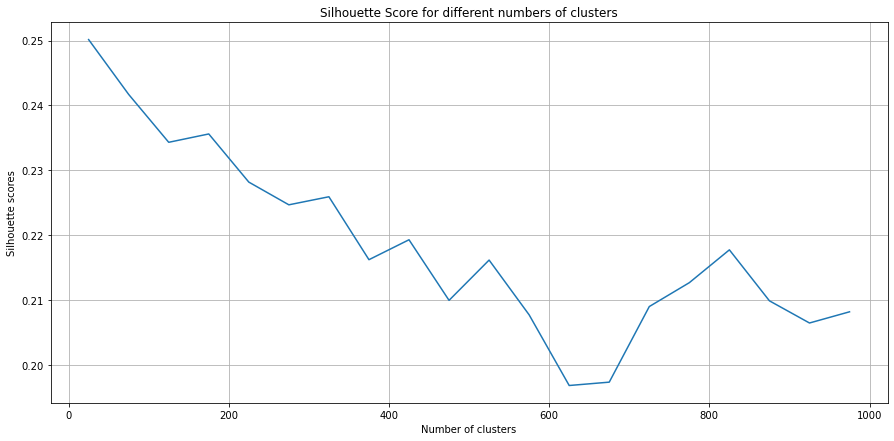

In [76]:
fig=plt.figure(figsize=(15,7))
plt.title("Silhouette Score for different numbers of clusters")
plt.plot(n_clusters, scores)
plt.ylabel("Silhouette scores")
plt.xlabel("Number of clusters")
plt.grid()

The silhouette scores of the clusters obtained from the LBP descriptors show better segmentation than the ones from BRISK but not as good as the ones from GLCM (the closer to 1 the better). k = 25 is still the best choice for this feature extraction method. Let's see if the visualizations provide better results.

In [77]:
# Apply kmeans for the whole dataset of descriptors with k = 25
k = 25
voc, variance = kmeans(descriptors_float, k, 1)

In [78]:
print(voc.shape)

(17, 640)


In [79]:
variance

32.53849134317593

In [80]:
clusters, _ = vq(descriptors_float, voc)
print(clusters.shape)

(228960,)


## Extracted Features Visualization

In [81]:
descriptors_cluster = np.hstack((descriptors_float,clusters.reshape(-1, 1)))
print(descriptors_cluster.shape)

(228960, 641)


### Principal Component Analysis __(PCA)__

In [82]:
def plot_pca(dataset):
    pca = PCA()
    pca_data = pca.fit_transform(dataset[:, :-1])
    array = pca.explained_variance_ratio_
    array = [round(elem, 4) for elem in array]
    array_acum = [0]*len(array)
    for i in range(len(array)):
        if i == 0:
            array_acum[i] = array[i]
        else:
            array_acum[i] = array_acum[i-1] + array[i]
    print('3 principal components explained variance: {}'.format(array[:3]))

    pca_data = np.hstack((pca_data, dataset[:, -1].reshape(-1, 1).astype('int')))

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs[0].plot(array_acum)
    axs[0].set_title('PCA cumulative explained variance by component')
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=pca_data[:, -1], palette='turbo', legend=False, ax=axs[1])
    axs[1].set_title('Two principal components point cloud hued by cluster')
    plt.axis('off')
    plt.show()

3 principal components explained variance: [0.2704, 0.0588, 0.0491]


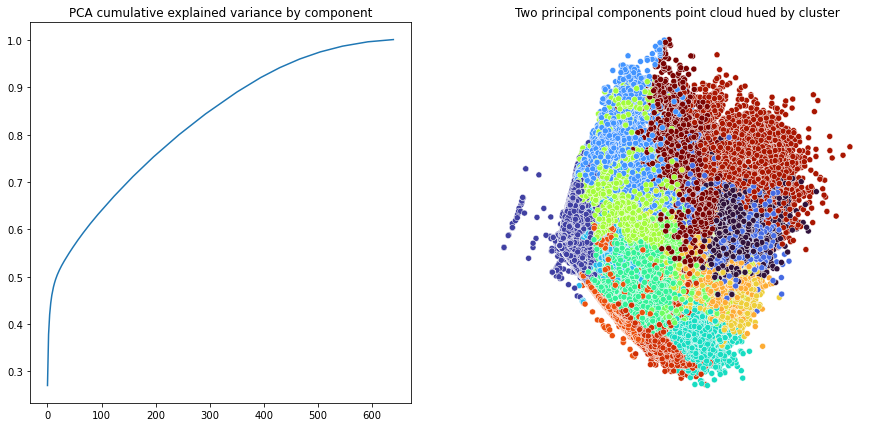

In [83]:
plot_pca(descriptors_cluster)

The first component obtained from PCA explains around 27% of the variance in the dataset, while the second one explains only 5.9%. The point cloud of the first two components show poor cluster segmentation and provides few insights to understand the descriptors produced by the LBP method.

### t-Distributed Stochastic Neighbor Embedding __(t-SNE)__

t-distributed Stochastic Neighbor Embedding (t-SNE) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two-dimensional map.

In [84]:
sample_tsne = np.random.choice(descriptors_cluster.shape[0], size = int(descriptors_cluster.shape[0]*0.01), replace = False)
descriptors_cluster_sample = descriptors_cluster[sample_tsne]
print(descriptors_cluster_sample.shape)

(2289, 641)


In [85]:
def plot_tsne(dataset):
    tsne_data = TSNE(n_components=2, perplexity=30).fit_transform(dataset[:, :-1])
    tsne_data = np.hstack((tsne_data, dataset[:, -1].reshape(-1, 1)))
    fig = plt.subplots(figsize=(7, 7))
    sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=tsne_data[:, -1].astype('int'), palette='turbo', legend=False)
    plt.title('t-SNE 2 components visualization of descriptors obtained')
    plt.axis('off')
    plt.show()

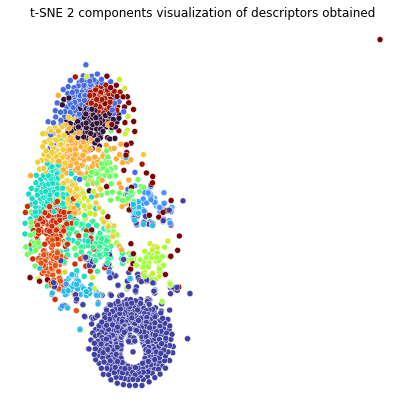

In [86]:
plot_tsne(descriptors_cluster_sample)

The two components produced by t-SNE produced a 2D point cloud visualization with better segmentation of the clusters than the one obtained by PCA.

## Training

In [32]:
adjusted_des_list = []

for item in des_list:
    if item[0] not in removal_list:
        #print(item[0])
        adjusted_des_list.append(item)

In [33]:
len(adjusted_des_list)

477

In [34]:
# Calculate the histogram of features and represent them as vector
# vq assigns codes from a code book to observations

im_features = np.zeros((len(adjusted_des_list), k), "float32")

for i in range(len(adjusted_des_list)):
    words, distance = vq(adjusted_des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1

In [35]:
im_features.shape

(477, 25)

In [36]:
# Scaling the words
# Standardize features by removing the mean and scaling to unit variance
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [37]:
labels_classes = {'Aluminium':0, 'Battery':1, 'Cable and Wire':2, 'Cardboard and Paper':3, 'Connector':4,
                'Copper':5, 'Iron':6, 'Magnetic Tape':7, 'Printed Circuit Board':8, 
                'Printer Ribbon and Toner':9, 'Tube and Screen':10, 'Water Pump':11}

list(labels_classes.keys())

['Aluminium',
 'Battery',
 'Cable and Wire',
 'Cardboard and Paper',
 'Connector',
 'Copper',
 'Iron',
 'Magnetic Tape',
 'Printed Circuit Board',
 'Printer Ribbon and Toner',
 'Tube and Screen',
 'Water Pump']

In [38]:
classesToRemove = []

for key in labels_classes:
    for string in removal_list:
        if key in string:
            #print(labels_classes[key])
            classesToRemove.append(labels_classes[key])

In [39]:
classesToRemove

[2, 2, 3, 3, 4, 4, 5, 6, 6, 9, 9, 9, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11]

In [40]:
len(classesToRemove)

22

In [41]:
def list_difference(b, a):
    c = list(b)
    for item in a:
        try:
            c.remove(item)
        except ValueError:
            pass            #or maybe you want to keep a values here
    return c

In [42]:
adjusted_image_classes = list_difference(image_classes, classesToRemove)

In [43]:
len(adjusted_image_classes)

477

In [44]:
classifiers = []
classifiers.append(('Logistic Regression', LogisticRegression(random_state=0, multi_class='multinomial', penalty='l2', solver='lbfgs')))
classifiers.append(('Multi-Layer Perceptron', MLPClassifier(random_state=0, activation='logistic', solver='lbfgs', warm_start=True)))
classifiers.append(('Support Vector Machine', SVC(random_state=0, kernel='rbf', C=1.0, gamma=10)))
classifiers.append(('Decision Tree', DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=20, min_samples_split=15, max_features='auto', min_impurity_decrease=1e-4)))
classifiers.append(('Random Forest', RandomForestClassifier(random_state=0, criterion='entropy', min_samples_split=30, max_depth=50, n_estimators=50)))
classifiers.append(('XGBoost', XGBClassifier(random_state=0, eval_metric='auc')))

In [45]:
def classifiers_func(im_features, image_classes):
    results = []
    models = []
    for model, clf in classifiers:
        cv = StratifiedKFold(n_splits=5)
        score = cross_val_score(clf, im_features, np.array(image_classes), cv=cv, scoring='accuracy', n_jobs=-1)
        results.append(score)
        models.append(model)
        msg = "%s: %f (%f)" % (model, score.mean(), score.std())
        print(msg)
    return results, models

In [47]:
results_lbp, models_lbp = classifiers_func(im_features, adjusted_image_classes)

Logistic Regression: 0.155000 (0.030653)
Multi-Layer Perceptron: 0.138289 (0.045692)
Support Vector Machine: 0.121667 (0.016197)
Decision Tree: 0.096316 (0.031711)
Random Forest: 0.146645 (0.027539)
XGBoost: 0.163421 (0.026397)


XGBoost got the highest accuracy in the cross validation training. So we'll fit this model in the entire train dataset of features.

In [48]:
# Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train XGBoost
clf = XGBClassifier(random_state=0, eval_metric='auc')
clf.fit(im_features, np.array(adjusted_image_classes))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [49]:
# Save the model parameters
# Joblib dumps Python object into one file
jb.dump((clf, training_names, stdSlr, k, voc), "bovw_segmented_balanced_lbp_xgboost.pkl", compress=3)

['bovw_segmented_balanced_lbp_xgboost.pkl']

This concludes the training step. Now we have 3 trained classifiers trained on features extracted by different methods: BRISK, GLCM and LBP.